In [1]:
import abc
import numpy as np
import tensorflow as tf

from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step


In [2]:
nest = tf.nest
class BanditPyEnvironment(py_environment.PyEnvironment):

  def __init__(self, observation_spec, action_spec):
    self._observation_spec = observation_spec
    self._action_spec = action_spec
    super(BanditPyEnvironment, self).__init__()

  # Helper functions.
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _empty_observation(self):
    return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                 self.observation_spec())

  # These two functions below should not be overridden by subclasses.
  def _reset(self):
    """Returns a time step containing an observation."""
    return ts.restart(self._observe(), batch_size=self.batch_size)

  def _step(self, action):
    """Returns a time step containing the reward for the action taken."""
    reward = self._apply_action(action)
    return ts.termination(self._observe(), reward)

  # These two functions below are to be implemented in subclasses.
  @abc.abstractmethod
  def _observe(self):
    """Returns an observation."""

  @abc.abstractmethod
  def _apply_action(self, action):
    """Applies `action` to the Environment and returns the corresponding reward.
    """


In [3]:
class SimplePyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')
    super(SimplePyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-2, 3, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return action * self._observation
environment = SimplePyEnvironment()
observation = environment.reset().observation
print("observation: %d" % observation)

action = 2 #@param

print("action: %d" % action)
reward = environment.step(action).reward
print("reward: %f" % reward)

tf_environment = tf_py_environment.TFPyEnvironment(environment)


class SignPolicy(tf_policy.TFPolicy):
  def __init__(self):
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
    time_step_spec = ts.time_step_spec(observation_spec)

    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=2)

    super(SignPolicy, self).__init__(time_step_spec=time_step_spec,
                                     action_spec=action_spec)
  def _distribution(self, time_step):
    pass

  def _variables(self):
    return ()

  def _action(self, time_step, policy_state, seed):
    observation_sign = tf.cast(tf.sign(time_step.observation[0]), dtype=tf.int32)
    action = observation_sign + 1
    return policy_step.PolicyStep(action, policy_state)
sign_policy = SignPolicy()

current_time_step = tf_environment.reset()
print('Observation:')
print (current_time_step.observation)
action = sign_policy.action(current_time_step).action
print('Action:')
print (action)
reward = tf_environment.step(action).reward
print('Reward:')
print(reward)
step = tf_environment.reset()
action = 1
next_step = tf_environment.step(action)
reward = next_step.reward
next_observation = next_step.observation
print("Reward: ")
print(reward)
print("Next observation:")
print(next_observation)



observation: -1
action: 2
reward: -2.000000
Observation:
tf.Tensor([[2]], shape=(1, 1), dtype=int32)
Action:
tf.Tensor([2], shape=(1,), dtype=int32)
Reward:
tf.Tensor([[4.]], shape=(1, 1), dtype=float32)
Reward: 
tf.Tensor([[-1.]], shape=(1, 1), dtype=float32)
Next observation:
tf.Tensor([[2]], shape=(1, 1), dtype=int32)


In [4]:
class TwoWayPyEnvironment(BanditPyEnvironment):

  def __init__(self):
    action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=-2, maximum=2, name='observation')

    # Flipping the sign with probability 1/2.
    self._reward_sign = 2 * np.random.randint(2) - 1
    print("reward sign:")
    print(self._reward_sign)

    super(TwoWayPyEnvironment, self).__init__(observation_spec, action_spec)

  def _observe(self):
    self._observation = np.random.randint(-2, 3, (1,), dtype='int32')
    return self._observation

  def _apply_action(self, action):
    return self._reward_sign * action * self._observation[0]

two_way_tf_environment = tf_py_environment.TFPyEnvironment(TwoWayPyEnvironment())

class TwoWaySignPolicy(tf_policy.TFPolicy):
  def __init__(self, situation):
    observation_spec = tensor_spec.BoundedTensorSpec(
        shape=(1,), dtype=tf.int32, minimum=-2, maximum=2)
    action_spec = tensor_spec.BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0, maximum=2)
    time_step_spec = ts.time_step_spec(observation_spec)
    self._situation = situation
    super(TwoWaySignPolicy, self).__init__(time_step_spec=time_step_spec,
                                           action_spec=action_spec)
  def _distribution(self, time_step):
    pass

  def _variables(self):
    return [self._situation]

  def _action(self, time_step, policy_state, seed):
    sign = tf.cast(tf.sign(time_step.observation[0, 0]), dtype=tf.int32)
    def case_unknown_fn():
      # Choose 1 so that we get information on the sign.
      return tf.constant(1, shape=(1,))

    # Choose 0 or 2, depending on the situation and the sign of the observation.
    def case_normal_fn():
      return tf.constant(sign + 1, shape=(1,))
    def case_flipped_fn():
      return tf.constant(1 - sign, shape=(1,))

    cases = [(tf.equal(self._situation, 0), case_unknown_fn),
             (tf.equal(self._situation, 1), case_normal_fn),
             (tf.equal(self._situation, 2), case_flipped_fn)]
    action = tf.case(cases, exclusive=True)
    return policy_step.PolicyStep(action, policy_state)


reward sign:
-1


In [5]:
class SignAgent(tf_agent.TFAgent):
  def __init__(self):
    self._situation = tf.Variable(0, dtype=tf.int32)
    policy = TwoWaySignPolicy(self._situation)
    time_step_spec = policy.time_step_spec
    action_spec = policy.action_spec
    super(SignAgent, self).__init__(time_step_spec=time_step_spec,
                                    action_spec=action_spec,
                                    policy=policy,
                                    collect_policy=policy,
                                    train_sequence_length=None)

  def _initialize(self):
    return tf.compat.v1.variables_initializer(self.variables)

  def _train(self, experience, weights=None):
    observation = experience.observation
    action = experience.action
    reward = experience.reward

    # We only need to change the value of the situation variable if it is
    # unknown (0) right now, and we can infer the situation only if the
    # observation is not 0.
    needs_action = tf.logical_and(tf.equal(self._situation, 0),
                                  tf.not_equal(reward, 0))


    def new_situation_fn():
      """This returns either 1 or 2, depending on the signs."""
      return (3 - tf.sign(tf.cast(observation[0, 0, 0], dtype=tf.int32) *
                          tf.cast(action[0, 0], dtype=tf.int32) *
                          tf.cast(reward[0, 0], dtype=tf.int32))) / 2

    new_situation = tf.cond(needs_action,
                            new_situation_fn,
                            lambda: self._situation)
    new_situation = tf.cast(new_situation, tf.int32)
    tf.compat.v1.assign(self._situation, new_situation)
    return tf_agent.LossInfo((), ())

sign_agent = SignAgent()
# We need to add another dimension here because the agent expects the
# trajectory of shape [batch_size, time, ...], but in this tutorial we assume
# that both batch size and time are 1. Hence all the expand_dims.

def trajectory_for_bandit(initial_step, action_step, final_step):
  return trajectory.Trajectory(observation=tf.expand_dims(initial_step.observation, 0),
                               action=tf.expand_dims(action_step.action, 0),
                               policy_info=action_step.info,
                               reward=tf.expand_dims(final_step.reward, 0),
                               discount=tf.expand_dims(final_step.discount, 0),
                               step_type=tf.expand_dims(initial_step.step_type, 0),
                               next_step_type=tf.expand_dims(final_step.step_type, 0))
step = two_way_tf_environment.reset()
for _ in range(10):
  action_step = sign_agent.collect_policy.action(step)
  next_step = two_way_tf_environment.step(action_step.action)
  experience = trajectory_for_bandit(step, action_step, next_step)
  print(experience)
  sign_agent.train(experience)
  step = next_step


Trajectory(
{'action': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]])>,
 'discount': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]])>,
 'observation': <tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[0]]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]])>})
Trajectory(
{'action': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]])>,
 'discount': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]])>,
 'observation': <tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[1]]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.]], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1, 1)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0.5, 0, 'Number of Iterations')

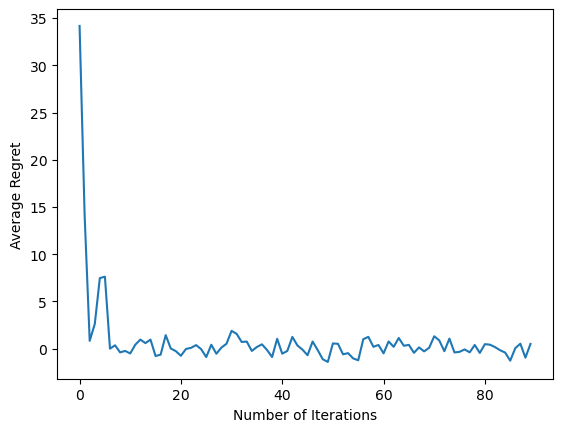

In [6]:
# Imports for example.
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_py_environment as sspe
from tf_agents.bandits.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib.pyplot as plt
batch_size = 2 # @param
arm0_param = [-3, 0, 1, -2] # @param
arm1_param = [1, -2, 3, 0] # @param
arm2_param = [0, 0, 1, 1] # @param
def context_sampling_fn(batch_size):
  """Contexts from [-10, 10]^4."""
  def _context_sampling_fn():
    return np.random.randint(-10, 10, [batch_size, 4]).astype(np.float32)
  return _context_sampling_fn

class LinearNormalReward(object):
  """A class that acts as linear reward function when called."""
  def __init__(self, theta, sigma):
    self.theta = theta
    self.sigma = sigma
  def __call__(self, x):
    mu = np.dot(x, self.theta)
    return np.random.normal(mu, self.sigma)

arm0_reward_fn = LinearNormalReward(arm0_param, 1)
arm1_reward_fn = LinearNormalReward(arm1_param, 1)
arm2_reward_fn = LinearNormalReward(arm2_param, 1)

environment = tf_py_environment.TFPyEnvironment(
    sspe.StationaryStochasticPyEnvironment(
        context_sampling_fn(batch_size),
        [arm0_reward_fn, arm1_reward_fn, arm2_reward_fn],
        batch_size=batch_size))
observation_spec = tensor_spec.TensorSpec([4], tf.float32)
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=2)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec)
def compute_optimal_reward(observation):
  expected_reward_for_arms = [
      tf.linalg.matvec(observation, tf.cast(arm0_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm1_param, dtype=tf.float32)),
      tf.linalg.matvec(observation, tf.cast(arm2_param, dtype=tf.float32))]
  optimal_action_reward = tf.reduce_max(expected_reward_for_arms, axis=0)
  return optimal_action_reward

regret_metric = tf_metrics.RegretMetric(compute_optimal_reward)
num_iterations = 90 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=batch_size,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())

plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')